In [37]:
# importing libraries
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
import inflect
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import graphviz
import pydotplus
from IPython.display import Image
from scipy.sparse import csr_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import time
from sklearn.preprocessing import FunctionTransformer
import seaborn as sns


In [38]:
# functions



# modified stop words so that they are without punctuation
def create_my_stop_words():
    my_stop_words = []       # stop words without punctuation
    for word in stopwords.words("english"): 
        my_word = ""
        for char in word:
            if char not in string.punctuation:
                my_word += char
        my_stop_words.append(my_word)

    other_not_included = ["hed", "itd", "theyd", "youd", "me"] # shed, wed, id are common words but he had, it had, they had, you had
    for word in other_not_included:
        my_stop_words.append(word)
    return my_stop_words


# plural word -> singular word
def singularize_word(word):
    p = inflect.engine()
    singular_word = p.singular_noun(word)
    if singular_word:
        return singular_word
    else:
        return word
    

# prepare dataset
def prepare_kaggle_dataset(df):
    df.fillna("", inplace=True) # filling empty fields
    df["combined"] = df[['Top1', "Top2", "Top3", 'Top4', 'Top5', 'Top6', 'Top7',
      'Top8', 'Top9', 'Top10', 'Top11', 'Top12', 'Top13', 'Top14', 'Top15',
      'Top16', 'Top17', 'Top18', 'Top19', 'Top20', 'Top21', 'Top22', 'Top23',
       'Top24', 'Top25']].apply(lambda row: " ".join(row), axis=1) # combining all columns into one
    
    new_df = pd.DataFrame(data={"combined": df["combined"], "label": df["Label"]})
    
    return new_df


#test = 0

# text cleaning 
def text_cleanning(row):
    global test
    remove_b = row.replace("b\"", "").replace("b'", "")   # removing b" and b'
    remove_punc = "".join([char for char in remove_b if char not in string.punctuation])     # removing punctuation !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
    remove_stop_words = [word for word in remove_punc.split() if word.lower() not in my_stop_words]  # removing stopwords
    


    # comparing different techniques for removing suffixis
    """
    for i in remove_stop_words:
        print(i, " : ", porter_stemmer.stem(i, to_lowercase=False), " : ", lemmatizer.lemmatize(i), " : ", singularize_word(i))
    """
    
    lem_words = [lemmatizer.lemmatize(word) for word in remove_stop_words] # base of the words

    singular_words = [singularize_word(word) for word in lem_words]         # plural -> singular
    #if "me" in singular_words or "Me" in singular_words:
     #   test += 1

    return " ".join(singular_words)  # returning cleaned row as a string


# get each word in Count Vectorizer with its count in 0, 1 and total
def get_word_counts():
    feature_names = tokenizer.get_feature_names_out()

    # Get the indices of the "0" and "1" texts in the DataFrame
    indices_0 = df[df["label"] == 0].index
    indices_1 = df[df["label"] == 1].index

    # Get the occurrences of each word in the "0" texts
    word_counts_0 = tokenized_words[indices_0].sum(axis=0)

    # Get the occurrences of each word in the "1" texts
    word_counts_1 = tokenized_words[indices_1].sum(axis=0)

    # Create a dictionary to store the word counts
    word_counts = {
        "word": feature_names,
        "count_0": word_counts_0.tolist()[0],
        "count_1": word_counts_1.tolist()[0],
    }
    

    # Create a DataFrame from the word counts dictionary
    word_counts_df = pd.DataFrame(word_counts)
    word_counts_df["count"] = word_counts_df["count_0"] + word_counts_df["count_1"]

    return word_counts_df


# printing the prob table
def print_probabilities():
    feature_log_probs = model.feature_log_prob_

    # Convert feature log probabilities to probabilities
    feature_probs = np.exp(feature_log_probs)

    sorted_vocabulary = sorted(tokenizer.vocabulary_.items(), key=lambda x: x[1])

    vocab_arr = [item[0] for item in sorted_vocabulary]

    # Create a DataFrame to represent the probabilistic table
    prob_table = pd.DataFrame(feature_probs, columns=vocab_arr)

    word_counts_df = get_word_counts()  # getting the counts
    word_counts_df.set_index("word", inplace=True)  # making the word column index so it will match the prob_table
    
    prob_table = prob_table.transpose().sort_index()
    prob_table["count"] = word_counts_df["count"]
    prob_table["count_0"] = word_counts_df["count_0"]
    prob_table["count_1"] = word_counts_df["count_1"]
    
    
    #for_csv = prob_table.reset_index()   # adding indexes back
    #for_csv.to_csv("words_for_analysis.csv")
    
    # probability ratio
    prob_table["prob_ratio"] =  prob_table.iloc[:,1] / prob_table.iloc[:, 0]
    
    # product of prob_ratio and count
    prob_table["product_ratio_count"] = prob_table["count"] * prob_table["prob_ratio"]

    # priting the dataframe to a txt file
    with open("output.txt", "w") as f:
        pd.set_option('display.max_rows', None)
        pd.set_option('display.max_columns', None)
        pd.set_option('display.width', None)
        pd.set_option('display.expand_frame_repr', False)
        #pd.set_option('display.max_colwidth', -1) 

        #print(prob_table.sort_values("pomer",  ascending=False), file=f) # sort by biggest impact on 0
        print(prob_table.sort_values("product_ratio_count", ascending=False), file=f)
        

        pd.reset_option('all')
        

# checking the performance
def my_confusion_matrix(data, predicted_col, true_col, up="up", down="down"):
    tp = data.loc[(data[predicted_col] == up) & (data[true_col] == up)]
    fp = data.loc[(data[predicted_col] == up) & (data[true_col] == down)]
    fn = data.loc[(data[predicted_col] == down) & (data[true_col] == up)]
    tn = data.loc[(data[predicted_col] == down) & (data[true_col] == down)]

    df = pd.DataFrame({"Actual up":[len(tp), len(fn)], "Actual Down":[len(fp), len(tn)]}, index=["Predicted up", "Predicted down"])

    performance = (len(tp) + len(tn)) / (len(tp) + len(tn) + len(fp) + len(fn))
    accuracyP = (len(tp) / (len(tp) + len(fp)))
    
    balance = 0.5*( (len(tp)/(len(tp)+len(fn))) + (len(tn)/(len(tn) + len(fp))))
    

    if (len(tn) + len(fn)) == 0:
        accuracyN = "no negatives predicted"
    else:
        accuracyN = (len(tn) / (len(tn) + len(fn)))
        
    return [balance, len(tp), len(fp), len(fn), len(tn)]

    


In [39]:
lemmatizer = WordNetLemmatizer()

my_stop_words = create_my_stop_words()

# load kaggle data
df = pd.read_csv("Combined_News_DJIA.csv")
df = prepare_kaggle_dataset(df)

# load news category data
#df_2 = pd.read_csv("news_category_data.csv")

# concatenate
#df = pd.concat([df, df_2], ignore_index=True)


# testing
#df = df.head(100)

df["combined"] = df['combined'].apply(text_cleanning)

In [6]:
def decision_tree_tuning(df):
    # every cycle randomly splitted into 10 parts

    all_results = []
    
    for min_df in range(24,131): # from 25 difference to 130

        tokenizer = CountVectorizer(analyzer="word", lowercase=False, min_df=min_df, ngram_range=(1, 1))
        tokenized_words = tokenizer.fit_transform(df["combined"])

        # training, validation, testing
        X_train, X_test, y_train, y_test = train_test_split(tokenized_words, df["label"], test_size=0.2,shuffle=True, random_state=42)
        X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, shuffle=True, random_state=42)

        results = []

        for min_samples_leaf in range(1, 10): # to 85

            for max_depth in range(1, 15): # no difference after 135
                #print(X_train.shape, X_val.shape, X_test.shape)
                model = DecisionTreeClassifier(random_state=42, max_depth=max_depth, min_samples_leaf=min_samples_leaf)
                model.fit(X_train, y_train)
                predict = model.predict(X_val)

                conf = pd.DataFrame({"Predicted": predict, "Actual":y_val})
                balance = my_confusion_matrix(conf, "Predicted", "Actual", up=1, down=0)[0]
                results.append([balance, min_samples_leaf, max_depth])

        best_result = max(results, key=lambda sublist: sublist[0])

        model = DecisionTreeClassifier(random_state=42, max_depth=best_result[2], min_samples_leaf=best_result[1])
        model.fit(X_train, y_train)
        predict = model.predict(X_test)
        conf = pd.DataFrame({"Predicted": predict, "Actual":y_val})
        print("Validation:", best_result[0])
        print("min_df:", min_df)
        print("min_samples_leaf:", best_result[1])
        print("max_depth:", best_result[2])
        print(my_confusion_matrix(conf, "Predicted", "Actual", up=1, down=0))
        print()
        
        all_results.append([best_result[0], min_df, best_result[1], best_result[2]])
    
    return all_results



all_results = decision_tree_tuning(df)

# Find the maximum element in the first column
max_value = max(row[0] for row in all_results)

# Find the subarray(s) with the maximum element in the first column
max_subarrays = [row for row in all_results if row[0] == max_value]

print(max_subarrays) # [[0.5678511108223984, 68, 7, 14]]

Validation: 0.5591247672253259
min_df: 24
min_samples_leaf: 7
max_depth: 13
[0.5025226278636699, 193, 133, 65, 46]

Validation: 0.5599800788185874
min_df: 25
min_samples_leaf: 6
max_depth: 13
[0.4977913472781603, 192, 134, 66, 45]

Validation: 0.529372915854662
min_df: 26
min_samples_leaf: 4
max_depth: 14
[0.5038326620761335, 198, 136, 60, 43]

Validation: 0.5341041964401715
min_df: 27
min_samples_leaf: 4
max_depth: 14
[0.506625958165519, 198, 135, 60, 44]

Validation: 0.5265796197652766
min_df: 28
min_samples_leaf: 7
max_depth: 13
[0.5063985968559179, 195, 133, 63, 46]

Validation: 0.5276622926681391
min_df: 29
min_samples_leaf: 4
max_depth: 12
[0.5143778961500152, 202, 135, 56, 44]

Validation: 0.5265796197652766
min_df: 30
min_samples_leaf: 4
max_depth: 12
[0.5160885193365381, 200, 133, 58, 46]

Validation: 0.5268069810748777
min_df: 31
min_samples_leaf: 6
max_depth: 12
[0.5115846000606297, 202, 136, 56, 43]

Validation: 0.5257243081720151
min_df: 32
min_samples_leaf: 4
max_depth: 1

Validation: 0.5358148196266943
min_df: 95
min_samples_leaf: 6
max_depth: 5
[0.5054891516175133, 183, 125, 75, 54]

Validation: 0.5339309687757134
min_df: 96
min_samples_leaf: 6
max_depth: 13
[0.4995019704646832, 190, 132, 68, 47]

Validation: 0.5358148196266943
min_df: 97
min_samples_leaf: 6
max_depth: 5
[0.5054891516175133, 183, 125, 75, 54]

Validation: 0.5390628383352821
min_df: 98
min_samples_leaf: 1
max_depth: 14
[0.48143215971590664, 185, 135, 73, 44]

Validation: 0.5358148196266943
min_df: 99
min_samples_leaf: 6
max_depth: 5
[0.5054891516175133, 183, 125, 75, 54]

Validation: 0.5343856913949158
min_df: 100
min_samples_leaf: 3
max_depth: 9
[0.5154605690528777, 204, 136, 54, 43]

Validation: 0.5375795764583604
min_df: 101
min_samples_leaf: 8
max_depth: 6
[0.5184270928067212, 194, 128, 64, 51]

Validation: 0.535186869343034
min_df: 102
min_samples_leaf: 3
max_depth: 14
[0.49648131306569654, 187, 131, 71, 48]

Validation: 0.5338768351305703
min_df: 103
min_samples_leaf: 4
max_depth:

In [7]:
def naive_bayes_tuning(df):
    all_results = []
    
    for min_df in range(24, 131):
        tokenizer = CountVectorizer(analyzer="word", lowercase=False, min_df=min_df, ngram_range=(1, 1))
        tokenized_words = tokenizer.fit_transform(df["combined"])

        # training, validation, testing
        X_train, X_test, y_train, y_test = train_test_split(tokenized_words, df["label"], test_size=0.2,shuffle=True, random_state=42)
        X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, shuffle=True, random_state=42)

        results = []

        for alpha in range(101): 
            alpha *= 0.01
            model = MultinomialNB(alpha=alpha, fit_prior=True)
            model.fit(X_train, y_train)
            predict = model.predict(X_val)

            conf = pd.DataFrame({"Predicted": predict, "Actual":y_val})
            balance = my_confusion_matrix(conf, "Predicted", "Actual", up=1, down=0)[0]
            results.append([balance, alpha])


        best_result = max(results, key=lambda sublist: sublist[0])

        model = MultinomialNB(alpha=best_result[1], fit_prior=True)
        model.fit(X_train, y_train)
        predict = model.predict(X_test)
        conf = pd.DataFrame({"Predicted": predict, "Actual":y_val})
        print("Validation:", best_result[0])
        print("min_df:", min_df)
        print("alpha:", best_result[1])
        print(my_confusion_matrix(conf, "Predicted", "Actual", up=1, down=0))
        print()
        
        all_results.append([best_result[0], min_df, best_result[1]])
        
    return all_results

all_results = naive_bayes_tuning(df)

# Find the maximum element in the first column
max_value = max(row[0] for row in all_results)

# Find the subarray(s) with the maximum element in the first column
max_subarrays = [row for row in all_results if row[0] == max_value]

print(max_subarrays) # [[0.5422675501277554, 121, 0.35000000000000003]]


Validation: 0.5125698324022346
min_df: 24
alpha: 0.4
[0.5061279286302023, 130, 88, 128, 91]

Validation: 0.505673206011
min_df: 25
alpha: 0.0
[0.5033346325408168, 130, 89, 128, 90]

Validation: 0.5153631284916201
min_df: 26
alpha: 0.18
[0.5024793209475553, 131, 90, 127, 89]

Validation: 0.5125698324022346
min_df: 27
alpha: 0.46
[0.49278939846693515, 126, 90, 132, 89]

Validation: 0.5117145208089732
min_df: 28
alpha: 0.4
[0.4977480403620458, 130, 91, 128, 88]

Validation: 0.5108592092157118
min_df: 29
alpha: 0.9400000000000001
[0.49409943267939893, 131, 93, 127, 86]

Validation: 0.5183837858906067
min_df: 30
alpha: 0.7000000000000001
[0.4996860248581698, 131, 91, 127, 88]

Validation: 0.5214044432895933
min_df: 31
alpha: 0.47000000000000003
[0.5119418821185744, 133, 88, 125, 91]

Validation: 0.5166731627040839
min_df: 32
alpha: 0.64
[0.5035619938504179, 133, 91, 125, 88]

Validation: 0.5177558356069465
min_df: 33
alpha: 0.5
[0.4968927287687844, 131, 92, 127, 87]

Validation: 0.518611147

Validation: 0.5355982850461218
min_df: 111
alpha: 0.96
[0.5091485860291889, 133, 89, 125, 90]

Validation: 0.5308670044606124
min_df: 112
alpha: 0.6900000000000001
[0.5121692434281755, 136, 90, 122, 89]

Validation: 0.5355982850461218
min_df: 113
alpha: 0.48
[0.511313931834914, 137, 91, 121, 88]

Validation: 0.5355982850461218
min_df: 114
alpha: 0.0
[0.5082932744359274, 134, 90, 124, 89]

Validation: 0.5252804122818414
min_df: 115
alpha: 0.0
[0.5063552899398034, 133, 90, 125, 89]

Validation: 0.5252804122818414
min_df: 116
alpha: 0.0
[0.4996860248581698, 131, 91, 127, 88]

Validation: 0.5328049889567363
min_df: 117
alpha: 0.0
[0.4996860248581698, 131, 91, 127, 88]

Validation: 0.5310943657702134
min_df: 118
alpha: 0.0
[0.5027066822571564, 134, 92, 124, 87]

Validation: 0.5319496773634749
min_df: 119
alpha: 0.0
[0.507437962842666, 135, 91, 123, 88]

Validation: 0.5338876618595989
min_df: 120
alpha: 0.0
[0.497975401671647, 133, 93, 125, 86]

Validation: 0.5422675501277554
min_df: 121
alp

In [46]:
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = train_test_split(df["combined"], df["label"], test_size=0.2,shuffle=True, random_state=42)
print(X_train.shape)

tokenizer = CountVectorizer(analyzer="word", lowercase=False, ngram_range=(1,1))
#tokenized_words = tokenizer.fit_transform(X_train["combined"])


estimator = MultinomialNB()

pipeline = Pipeline([
    ("tokenizer", tokenizer),
    ("estimator", estimator)
])

param_grid = {
    "tokenizer__min_df": [i for i in range(20, 125)],
    #"custom__min_df": [i for i in range(10)],
    "estimator__alpha": [i * 0.1 for i in range(10)],
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring="balanced_accuracy")

start_time = time.time()

grid_search.fit(X_train, y_train)

end_time = time.time()

fitting_time = end_time - start_time

print(fitting_time)


(1591,)


/Users/filipneubauer/Desktop/bayes/.venv/lib/python3.10/site-packages/sklearn/naive_bayes.py:629: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
/Users/filipneubauer/Desktop/bayes/.venv/lib/python3.10/site-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
/Users/filipneubauer/Desktop/bayes/.venv/lib/python3.10/site-packages/sklearn/naive_bayes.py:629: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
/Users/filipneubauer/Desktop/bayes/.venv/lib/python3.10/site-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchan

/Users/filipneubauer/Desktop/bayes/.venv/lib/python3.10/site-packages/sklearn/naive_bayes.py:629: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
/Users/filipneubauer/Desktop/bayes/.venv/lib/python3.10/site-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
/Users/filipneubauer/Desktop/bayes/.venv/lib/python3.10/site-packages/sklearn/naive_bayes.py:629: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
/Users/filipneubauer/Desktop/bayes/.venv/lib/python3.10/site-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchan

/Users/filipneubauer/Desktop/bayes/.venv/lib/python3.10/site-packages/sklearn/naive_bayes.py:629: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
/Users/filipneubauer/Desktop/bayes/.venv/lib/python3.10/site-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
/Users/filipneubauer/Desktop/bayes/.venv/lib/python3.10/site-packages/sklearn/naive_bayes.py:629: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
/Users/filipneubauer/Desktop/bayes/.venv/lib/python3.10/site-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchan

KeyboardInterrupt: 

In [44]:
print(grid_search.best_params_)

best_model = grid_search.best_estimator_

predict = best_model.predict(X_test)
conf = pd.DataFrame({"Predicted": predict, "Actual":y_test})
print(my_confusion_matrix(conf, "Predicted", "Actual", up=1, down=0))

{'estimator__alpha': 0.8, 'tokenizer__min_df': 23}
[0.5084499059690342, 118, 86, 109, 85]


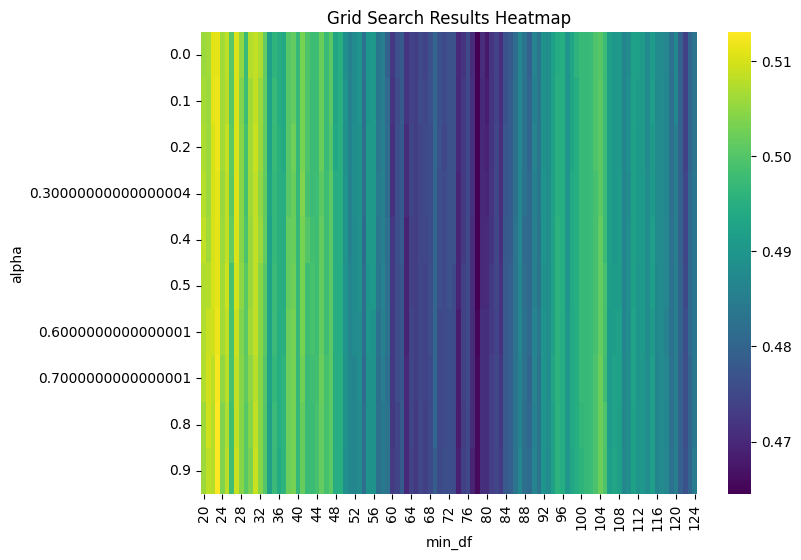

In [45]:
results = grid_search.cv_results_

#print(results)

param_grid_keys = list(param_grid.keys())
param_values = [results[f'param_{key}'] for key in param_grid_keys]

mean_test_scores = results['mean_test_score']
results_df = pd.DataFrame({'alpha': param_values[0], 'min_df': param_values[1], 'Mean_Test_Score': mean_test_scores})

heatmap_data = results_df.pivot(index='min_df', columns='alpha', values='Mean_Test_Score')

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=False, cmap='viridis', fmt='.3f', cbar=True)
plt.title('Grid Search Training Heatmap Naive Bayes')
plt.xlabel('min_df')
plt.ylabel('alpha')
plt.show()